In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_1.csv
/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_LIST_EVENTS.csv
/kaggle/input/unsw-nb15/UNSW-NB15_4.csv
/kaggle/input/unsw-nb15/UNSW-NB15_3.csv
/kaggle/input/unsw-nb15/UNSW-NB15_2.csv
/kaggle/input/unsw-nb15/NUSW-NB15_features.csv


In [2]:
# Load datasets
training = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")
testing = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")

In [3]:
# Concatenate datasets and drop 'id' column
df = pd.concat([training, testing]).drop('id', axis=1)
df.reset_index(drop=True, inplace=True)

In [4]:
# Convert categorical columns to numeric
for col in ['proto', 'service', 'state']:
    df[col] = df[col].astype('category').cat.codes

# Convert 'attack_cat' to categorical
df['attack_cat'] = df['attack_cat'].astype('category')

In [5]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target variable (y)
X = df.drop(columns=['attack_cat', 'label'])
y = df['label'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
import numpy as np
from tqdm import tqdm

In [7]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

class Beluga:
    def __init__(self, num_features):
        self.position = np.random.choice([0, 1], size=num_features)
        self.fitness = float('inf')

def fitness(X_train, y_train, X_test, y_test, selected_features):
    selected_indices = np.where(selected_features)[0].tolist()  # Convert indices to a list
    
    if len(selected_indices) == 0:
        return float('inf')  # Penalize for selecting no features
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train.iloc[:, selected_indices], y_train)  # Use iloc for integer-location indexing
    y_pred = clf.predict(X_test.iloc[:, selected_indices])
    return 1 - accuracy_score(y_test, y_pred)

def beluga_whale_optimization(X_train, y_train, X_test, y_test, num_belugas=10, max_iter=10):
    num_features = X_train.shape[1]
    belugas = [Beluga(num_features) for _ in range(num_belugas)]
    global_best_position = np.zeros(num_features)
    global_best_fitness = float('inf')

    for iteration in range(max_iter):
        a = 2 - iteration * (2 / max_iter)  # Linearly decreasing parameter
        for beluga in tqdm(belugas, desc=f"Iteration {iteration+1}/{max_iter}"):
            r1 = np.random.rand()
            r2 = np.random.rand()
            A = 2 * a * r1 - a  # Similar to WOA's encircling prey
            C = 2 * r2  # Similar to WOA's bubble-net behavior
            
            # Choose a strategy based on beluga social behavior
            if np.random.rand() < 0.5:
                # Social cooperation: Beluga whales work together
                D = np.abs(C * global_best_position - beluga.position)
                new_position = global_best_position - A * D
            else:
                # Exploration: Individual beluga randomly searches
                D = np.abs(C * beluga.position - np.random.choice(belugas).position)
                new_position = beluga.position + A * D

            # Apply new position
            beluga.position = np.clip(new_position, 0, 1).astype(int)

            # Evaluate fitness
            beluga.fitness = fitness(X_train, y_train, X_test, y_test, beluga.position)

            # Update global best position
            if beluga.fitness < global_best_fitness:
                global_best_position = beluga.position
                global_best_fitness = beluga.fitness

    return global_best_position

# Apply BWO algorithm to select features
selected_features = beluga_whale_optimization(X_train, y_train, X_test, y_test, num_belugas=10, max_iter=2)
selected_indices = np.where(selected_features)[0].tolist()  # Convert indices to a list
X_train_selected = X_train.iloc[:, selected_indices]  # Use iloc for integer-location indexing
X_test_selected = X_test.iloc[:, selected_indices]
print("Selected features:", selected_indices)


Iteration 2/2: 100%|██████████| 10/10 [03:44<00:00, 22.40s/it]

Selected features: [0, 1, 3, 5, 6, 8, 9, 10, 11, 13, 15, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 35, 38]


In [8]:
print(f"Number of classes: {df['attack_cat'].nunique()}, Class names: {df['attack_cat'].cat.categories.tolist()}")

Number of classes: 10, Class names: ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']


In [10]:
from sklearn.preprocessing import RobustScaler

# Scaling the selected features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# Reshape for the model
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, 1, X_test_scaled.shape[1])
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

2024-09-14 07:20:18.583218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 07:20:18.583352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 07:20:18.738668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
# Import necessary libraries
from keras.layers import Dense, SimpleRNN, Bidirectional, LSTM
from keras.models import Sequential
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Example Data Preparation (Assume X, y are your features and labels)
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for the RNN model (3D input required for RNNs)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Convert labels to categorical (Assuming classification task)
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(units=64, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Bidirectional(LSTM(units=64)))  # BiLSTM layer
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer for classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=20, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model using reshaped test data
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
print(f'Test Accuracy: {accuracy}')


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2577/2577 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8751 - loss: 0.2418 - val_accuracy: 0.9094 - val_loss: 0.1764
Epoch 2/20
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9056 - loss: 0.1795 - val_accuracy: 0.9048 - val_loss: 0.1746
Epoch 3/20
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9105 - loss: 0.1689 - val_accuracy: 0.9127 - val_loss: 0.1634
Epoch 4/20
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9129 - loss: 0.1655 - val_accuracy: 0.9135 - val_loss: 0.1623
Epoch 5/20
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9144 - loss: 0.1610 - val_accuracy: 0.9141 - val_loss: 0.1640
Epoch 6/20
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9163 - loss: 0.1580 - val_accuracy: 0.9167 - val_loss: 0.1585
Epoch 7/20
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9156 - loss: 0.1587 - val_accuracy: 0.9171 - val_loss: 0.1564
Epoch 8/20
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9178 - loss: 0.1551 - val

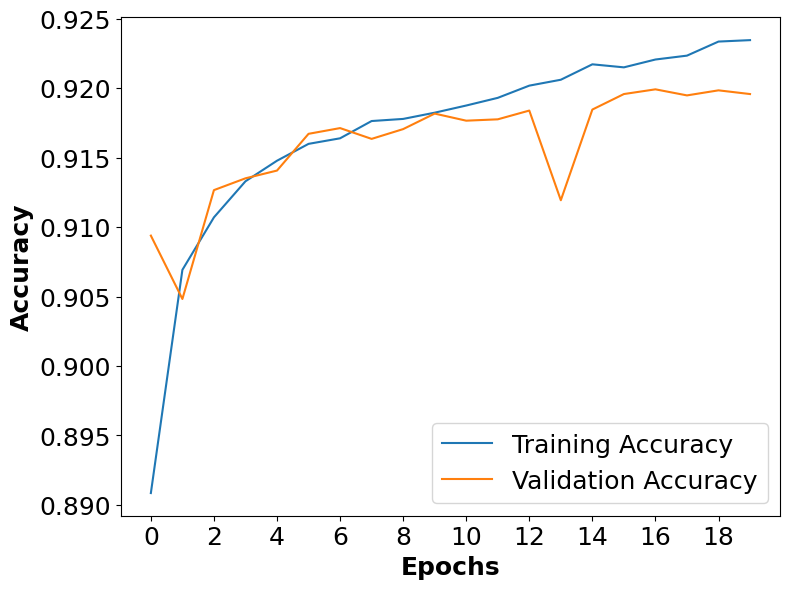

In [16]:
import matplotlib.pyplot as plt
# Plotting epoch versus accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Epoch vs Accuracy',weight='bold')
plt.xlabel('Epochs',weight='bold',fontsize=18)
plt.ylabel('Accuracy',weight='bold',fontsize=18)
plt.xticks(np.arange(0, len(history.history['accuracy']), step=2)) 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.tight_layout()
plt.show()

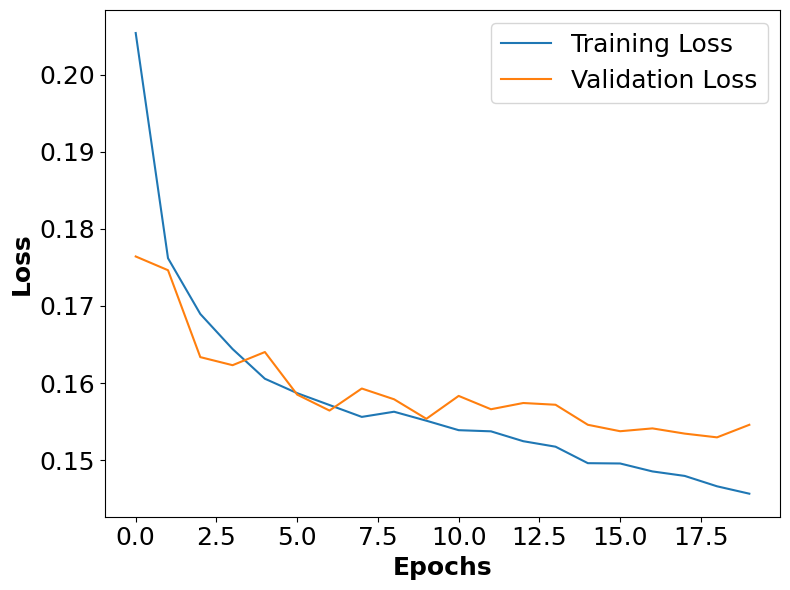

In [17]:
# Plotting epoch versus loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Epoch vs Loss',weight='bold')
plt.xlabel('Epochs',weight='bold',fontsize=18)
plt.ylabel('Loss',weight='bold',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.tight_layout()
plt.show()

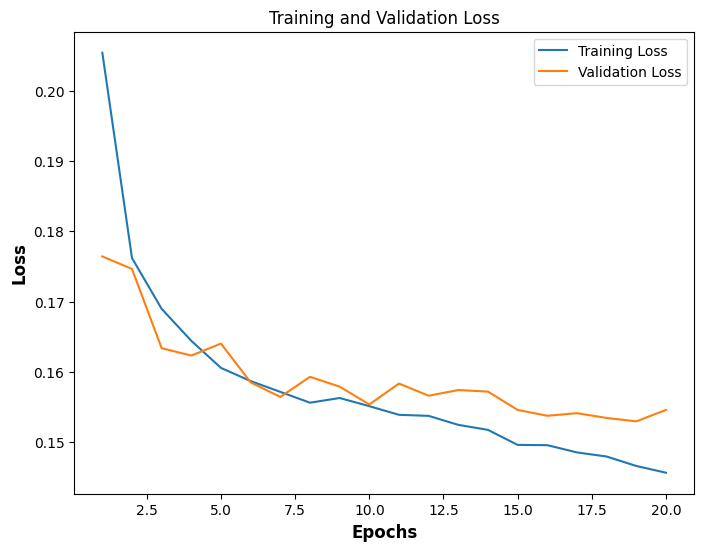

In [18]:
import matplotlib.pyplot as plt

# Access training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(8, 6))
# plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs',weight='bold',fontsize='large')
plt.ylabel('Loss',weight='bold',fontsize='large')
plt.legend()

In [23]:
from sklearn.metrics import recall_score

# Predict on the test set
y_pred_probs = model.predict(X_test_reshaped)

# Convert probabilities to class predictions (select class with highest probability)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ensure y_test is in a compatible format (not one-hot encoded)
y_test_labels = np.argmax(y_test_encoded, axis=1)

# Calculate recall score for multi-class classification
recall = recall_score(y_test_labels, y_pred, average='macro')  # You can use 'micro', 'macro', or 'weighted' depending on the use case
print("Recall: ", recall)

# Extract and print validation accuracy and loss
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

print(f"Validation Accuracy: {val_accuracy[-1]}")
print(f"Validation Loss: {val_loss[-1]}")


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Recall:  0.912649245796332
Validation Accuracy: 0.9195692539215088
Validation Loss: 0.15458428859710693


In [25]:
from sklearn.metrics import classification_report
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred,digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.8992    0.8814    0.8902     18675
           1     0.9334    0.9439    0.9386     32860

    accuracy                         0.9212     51535
   macro avg     0.9163    0.9126    0.9144     51535
weighted avg     0.9210    0.9212    0.9211     51535



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 18})
# plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels',fontsize=18,weight='bold')
plt.ylabel('True Labels',fontsize=18,weight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()